In [1]:
import numpy as np
import pandas as pd
import re
import DataProject_Functions as dp
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams["figure.dpi"] = 300

# Introduction

Every year, thousands of immigrant visas are granted to foreign workers and their immediate family based on their job skills. Some forms of visa application require an individual to already have a job lined up in the United States to apply for a visa. In such cases, the foreign worker must first obtain a Permanent Certification of Labor (PERM) from the U.S. Department of Labor before they can submit an immigration petition to the Department of Homeland Security’s U.S. Citizenship and Immigration Services (USCIS) to apply for a U.S. Permanment Visa. The PERM verifies that there are not enough qualified and willing U.S. workers to fill the position being offered at the offered wage. The certification also shows that the foreign worker will not negatively affect the wages and working conditions of similarly employed U.S. workers. 
We want to answer the following questions about the Permanent Certification of Labor (PERM): 

I. What is the likelihood of an individual getting certified by the Department of Labor given their background?

II. Which variables have significant negative effects on receiving a PERM?

III. Which variables have significant positive effects on receiving a PERM?

These questions are very compelling because knowing what factors  attribute to getting a labor certification will help both employers and employees understand the foreign worker application process. It would also be interesting to see what attributes are not beneficial in helping an individual become labor certified. Understanding how the United States PERM process works can shed light on what the United States Department of Labor is looking for in terms of accepting foregin workers into the United States. We can also see if there is bias and flaws in their decisions and how the immigration system can be improved in the United States. 

The dataset we will use is U.S. Permanent Visa Applicants, which can be found on kaggle.com. This dataset includes PERM application data from the years 2012-2016 and can be downloaded in a csv table. (link: https://www.kaggle.com/jboysen/us-perm-visas/data). The Department of Labor discloses the PERM information every year. Since this dataset comes from the U.S. Department of Labor, we believe that it is reliable and that the information given is accurate. We also think that there should not be a bias other than people filling out their information wrong due to misunderstanding of the question.

Extensive research on Permanent Certification of Labor applicants has not been done. However, we expect to find that occupations based on computers and technology are more likely to be certified than other occupations, such as janitoral services, poultry processing, and limited servies restaurants. We also expect that workers applying for jobs in states with large cities, such as New York, California, Washington, Texas, and Florida are more likely to get certified. We also predict foreign workers with higher education have higher chances of getting certified. 

# Cleaning Data

## Importing dataset

In [3]:
data = pd.read_csv("us_perm_visas.csv",low_memory=False)

In [4]:
data.shape

(374362, 154)

There are 374,362 data points with 154 factors in the dataset found on Kaggle. Each data point is specific information on an applicant, and each column represents a specific piece of data found on the application. Some of the important factors are state of the company sponsoring the applicant (`employer_state`), job title (`naics_title`), whether the applicant is refiling their application (`refile`), and the citizenship of the applicant (`country_of_citizenship`).

There are also some factors such as data about recruitment fliers and postal codes that will not provide relevant information to the questions of interest. These factors will be removed from the dataset.

### Removing Columns

The code `pd.isnull().sum()` determines the number of applicants with empty data for each factor. Any factor with majority of the data left blank is removed. For example, there are 374,081 applicants that have no information on the variable `orig_file_date`. This means that there are only 281 applicants that have information on this column. Since almost all of the applicants do not have information on this column, the column is removed. 

Note that we are not removing every single column that have majority of empty rows. For example, `naics_2007_us_title` (the standardized job title of applicant) have 354462 empty rows, however, this column represents the same information in `naics_us_title`, `naics_us_title_2007` and `naics_title`. All four of the data points combined will cover almost every row in the dataset. Therefore, caution is taken not to remove variables like these, but rather merge our dataset so they are just one column.

We also dropped the columns that are related to the columns that are dropped or have no numerical or categorical siginificance. An example of this kind of data is the naic_code which is a code for the name of the job title. Since we have already included the actual title of the job, we decided to neglect the code.

In [5]:
b = data.isnull().sum()
# Sample of variables we deleted because majority of the rows are empty. 
b.sort_values(ascending=False).head(5)

orig_file_date                 374081
orig_case_no                   374068
recr_info_job_fair_to          372569
recr_info_job_fair_from        372564
recr_info_on_campus_recr_to    372497
dtype: int64

In [6]:
#Drop the columns
data = dp.drop_columns(data)

## Merging Columns
Because this data set pulled from various applications over the years, the variables names were not consistent. Therefore, these factors are merged into one column. First, we check to make sure the columns are disjoint; if both columns have values in the same row, we individually look at the row to see how to merge the columns correctly. We verified that the columns are indeed disjoint and merged the columns. 

In [7]:
#merge all columns
data = dp.merge_columns(data)

## Standardize Column Information and Change Variable Types
Some columns in the dataset have inconsistent information. For example, `pw_unit_of_pay_9089` is the applicant's unit of pay: yearly, hourly, etc. However, the inputs consist of `yr`, `mth`, `bi`, `hr`, `wk`, `Hour`, `Bi-Weekly`, `Month`, `Week`, `Year`. We standardized these to be `Hour`, `Bi-Weekly`, `Month`,  `Week`, `Year`. The column `employer_state` also has some states written in abreviation while others were spelled out. All of the states were changed to the abbreviated form.

There are also a lot of different variable types that are stored in the dataframe as strings. The following columns are converted into their proper variable types:



I. Turn time variables (`decision_data`, `foreign_worker_yr_rel_edu_completed`, `employer_yr_estab`) into pandas `datetime` objects.

II. Turn `pw_amount_9089` into floats.

III. Turn 'Y' or 'N' variables (`recr_info_coll_univ_teacher`, `recr_info_employer_rec_payment`, `recr_info_professional_occ`, `refile`, `ri_layoff_in_past_six_months`, `ji_live_in_domestic_service`, `job_info_foreign_ed`, `job_info_foreign_lang_req`, `job_info_experience`) into boolean objects.

IV. Turn None to NaN in `foreign_worker_info_education` and `foreign_worker_info_education_other`.

V. Turn `decision_date` to year 


Lastly, we combine duplicate `case_number` data and set `case_number` as our index. Since case numbers are unique, we do not have to worry about losing data here.

In [8]:
data = dp.standardize_column_info(data)

# Feature Engineering

## Remove Withdrawn Applications
Currently the response variable has the values Certified, Withdrawn, Certified-Expired, and Denied as the applicant's case status. The rows where the application has been withdrawn are not helpful in this research, since the purpose of this analysis is to understand the likelihood of a person being certified. Therefore, these rows were removed. The Certified-Expired label means that the person was certified for the permanent labor certifications but did not file a form called a 140 within a 6 month period, meaning that their permanent visa expired. Since the individuals whose applications are Certified-Expired were certified at one point, we decided to group them with the other Certified applications.

## Adding Medical School to Education 
In the column `foreign_worker_info_education`, applicants indicated the level of their education. If their highest level of education was not High Schoool, Bachelor's, Master's, Doctorate, or Associate's, they may indicate Other in that column. In that case, there is another column `foreign_worker_info_education_other` where those individuals can specify what type of education was completed. Since almost every individual who filled in this column has a different answer, this row may not be very helpful for the analysis. The `foreign_worker_info_education_other` column has a lot of individuals with medical degrees. Since it would be interesting to analyze applicants with a medical degree, we used regular expressions to find the rows that indicated that they got a medical degree and added it to the `foreign_worker_info_education` column. We then deleted the `foreign_worker_info_education_other` column. 

##  If Applicants Used Agency or Not
Some applicants used certain agencies to help them with their application process. Some examples of agency information given in the data are name of the agency and location of the agency. These specific details are not very important to the analysis. However, exploring the likelihood of an individual getting PERM certified based on whether they have used an agency or not would be interesting.  Thus, we used the `agent_firm_name` column to create a boolean variable, with `True` signifying an agency was used, or `False` signifying no agency was used.

In [9]:
data = dp.feature_engineering(data)
data.shape

(354849, 23)

Our data is finally cleaned and ready for analysis. It has 23 variables and 354849 data points.

In [10]:
data.columns

Index(['case_status', 'class_of_admission', 'country_of_citizenship',
       'decision_date', 'employer_num_employees', 'employer_state',
       'employer_yr_estab', 'foreign_worker_info_education',
       'foreign_worker_yr_rel_edu_completed', 'ji_live_in_domestic_service',
       'job_info_experience', 'job_info_experience_num_months',
       'job_info_foreign_ed', 'job_info_foreign_lang_req', 'naics_title',
       'pw_amount_9089', 'pw_unit_of_pay_9089', 'recr_info_coll_univ_teacher',
       'recr_info_employer_rec_payment', 'recr_info_professional_occ',
       'refile', 'ri_layoff_in_past_six_months', 'used_agency'],
      dtype='object')

# Visualization and Analysis

The conclusions in the analysis are dependent on certification ratio and numbers. Thus, define a subset of the dataset, `certified`, which only looks at applications that are certified. This helps us determine patterns and ratios easier.

In [11]:
certified = data[data["case_status"] == "Certified"]

## Employer States
Do the location of the employers have an effect on certification statuses? Note that there are 57 states in the dataset because the dataset includes U.S. territories like the Virgin Islands, Guam, Puerto Rico, etc.

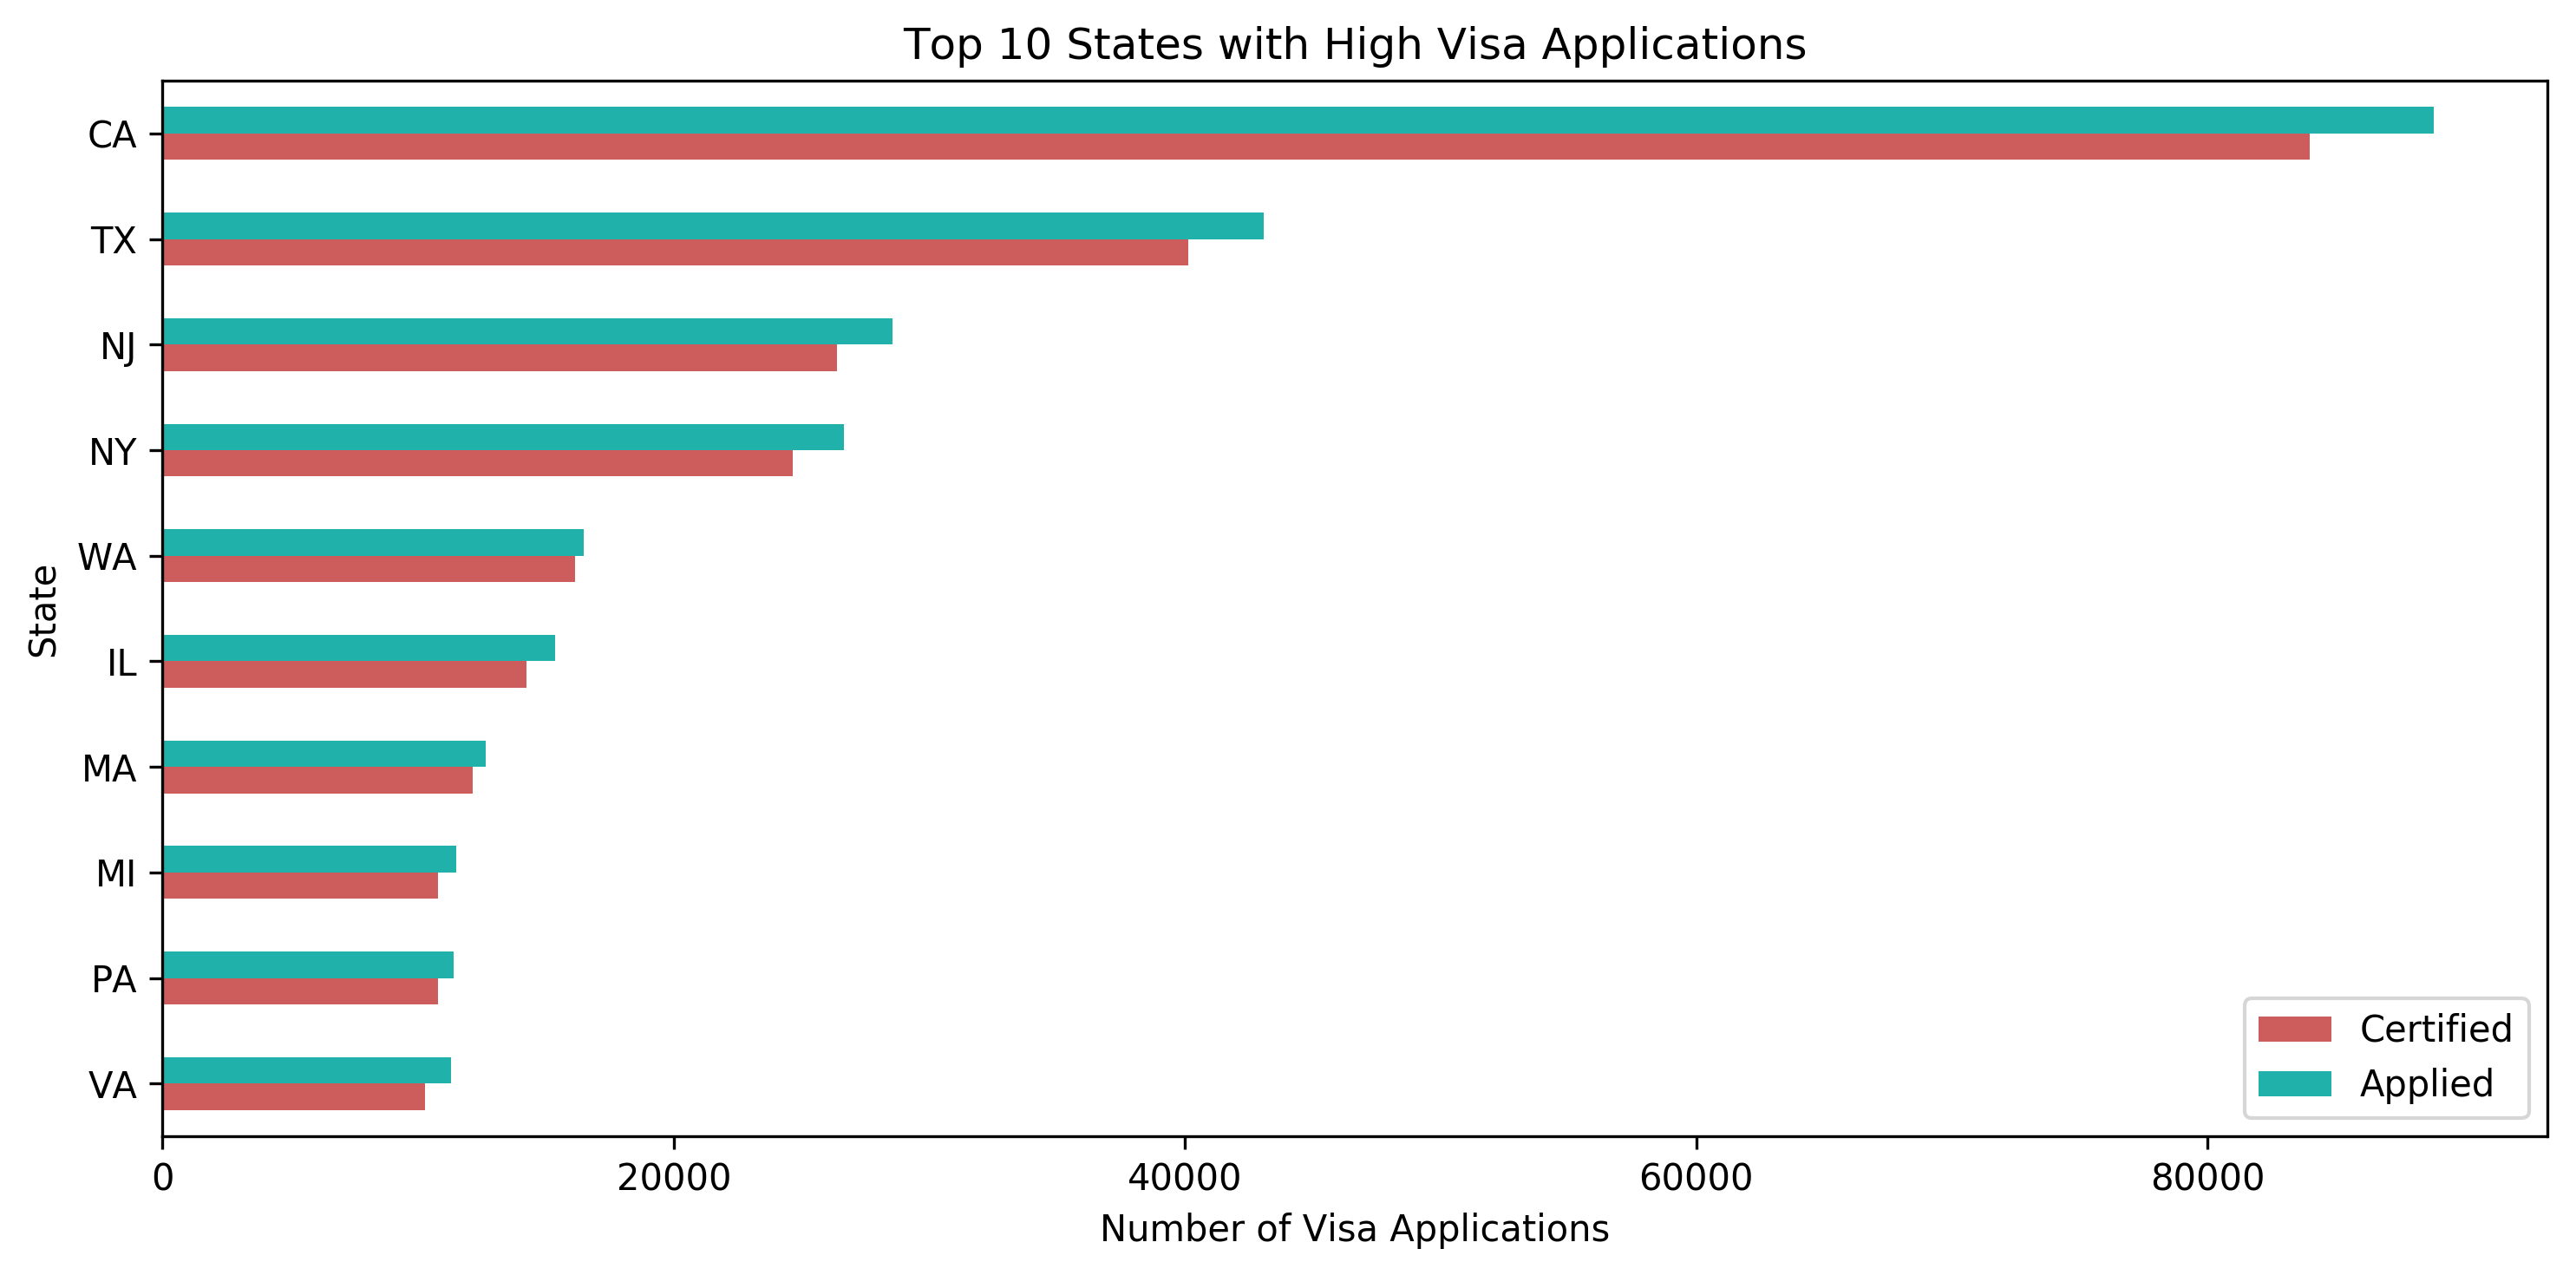

In [12]:
# Get the table of employer state counts and plot the count. 
state_count = dp.count_data("employer_state",data)
dp.plot_summary_data(state_count.head(10),
                  "Top 10 States with High Visa Applications","State")

The plot above consists of data of the ten states that have the most number of applicants along with the number of applications that were certified. As predicted, there is a high volume of immigration applicants from states with bigger cities including California, Texas, New York, and Washington. We also see that there are a lot more applicants from California than any other states. Notice that majority of the applicants in these states get certified. It would be interesting to see if this is the same case for other states. 

Certified ratio in a given group is defined to be the number of applicants that are certified divided by the number of total applicants for that group. The average certified ratios are calculated below. 

In [13]:
# Calculate the average certified ratio of top 10 states vs. overall. 
print("Bottom half avg:\t{}".format(state_count.ratio.tail(10).mean()))
print("Top half avg:\t{}".format(state_count.ratio.head(10).mean()))
print("Total avg:\t\t{}".format(state_count.ratio.mean()))

Bottom half avg:	0.8308623511361801
Top half avg:	0.938647187611869
Total avg:		0.8976729894722341


The calculations above revealed that the average certified ratio of all applicants is .898. This means that about 89.8% of all of the applicants got certified. The calculation also revealed that the average certified ratio of applicants of the top 10 states in application number is at .939 and the bottom 10 states is 0.831. The states that have a higher volume of applicants have a higher certified-ratio on average. 

## Foreign Worker Job Title

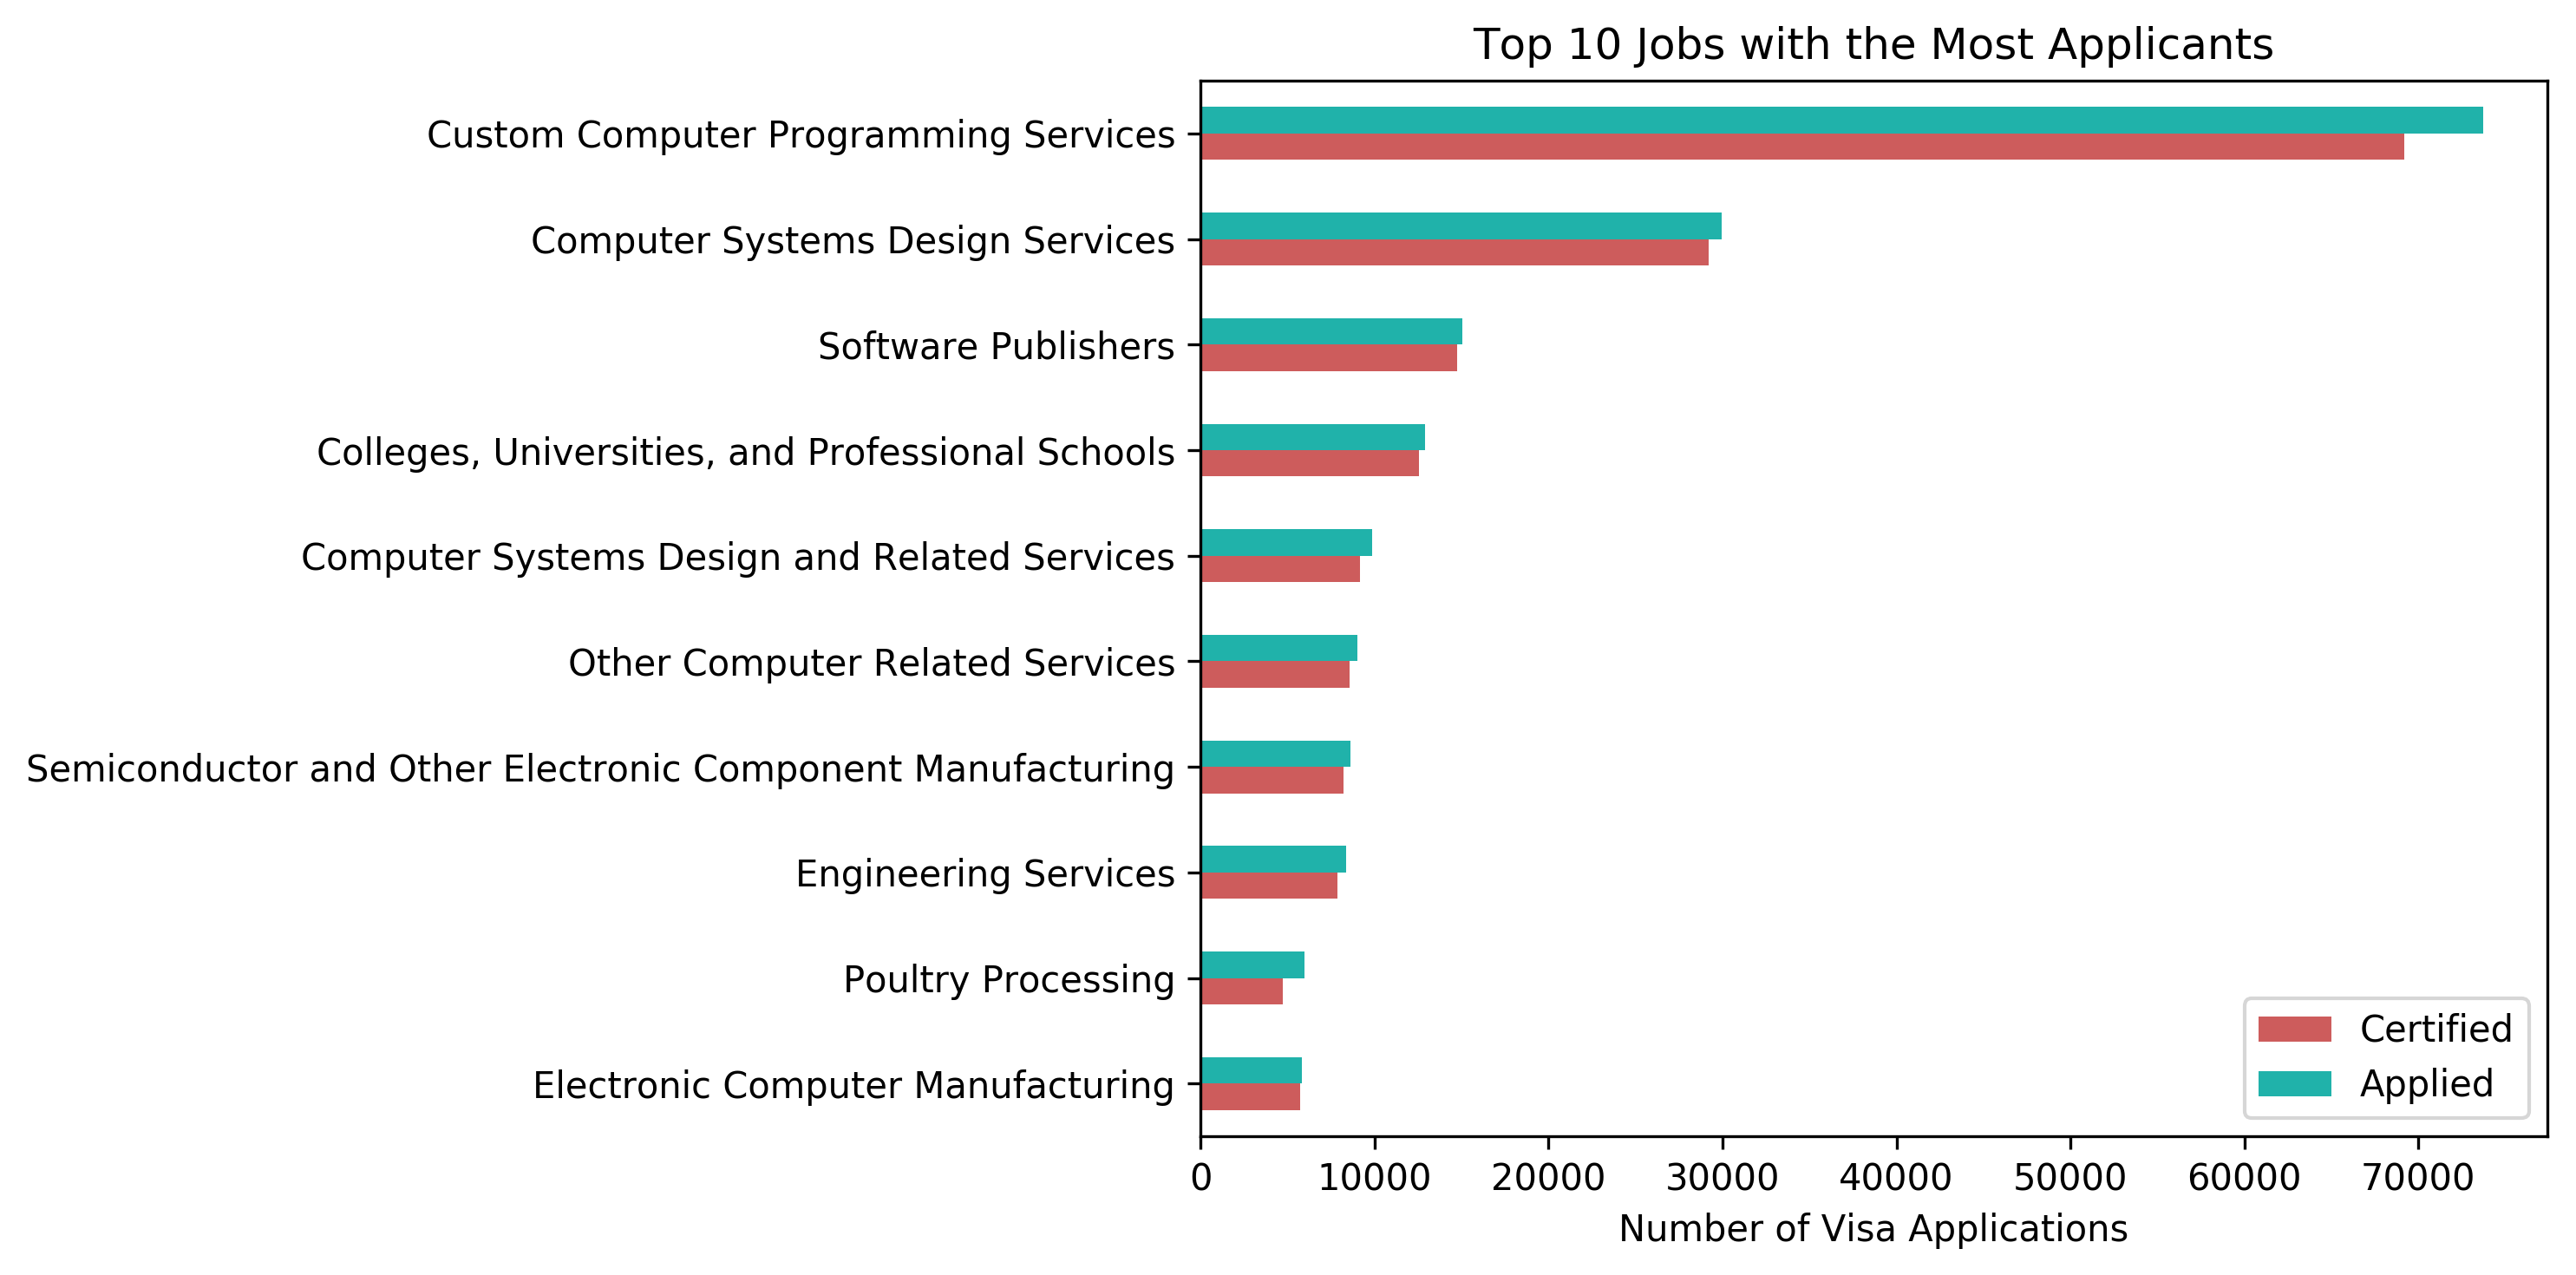

In [14]:
# Get the job count table and plot the top 10 job titles. 
job_count = dp.count_data("naics_title",data)
dp.plot_summary_data(job_count.head(10),
          "Top 10 Jobs with the Most Applicants","")

The graph above displays the top 10 jobs that the foreign worker applicants are employed for in the United States. Note that half of the job titles are related to computer science. 

The rank of job title is defined to be the rank based on the number of applicants in each job. Therefore, the rank of Custom Computer Programming Services, which has the highest number of applicants, would be 1, while the job title with the lowest number of applicants is ranked at 1560. The graph below plots the certified ratio of each job title based on ranking of the job title. 

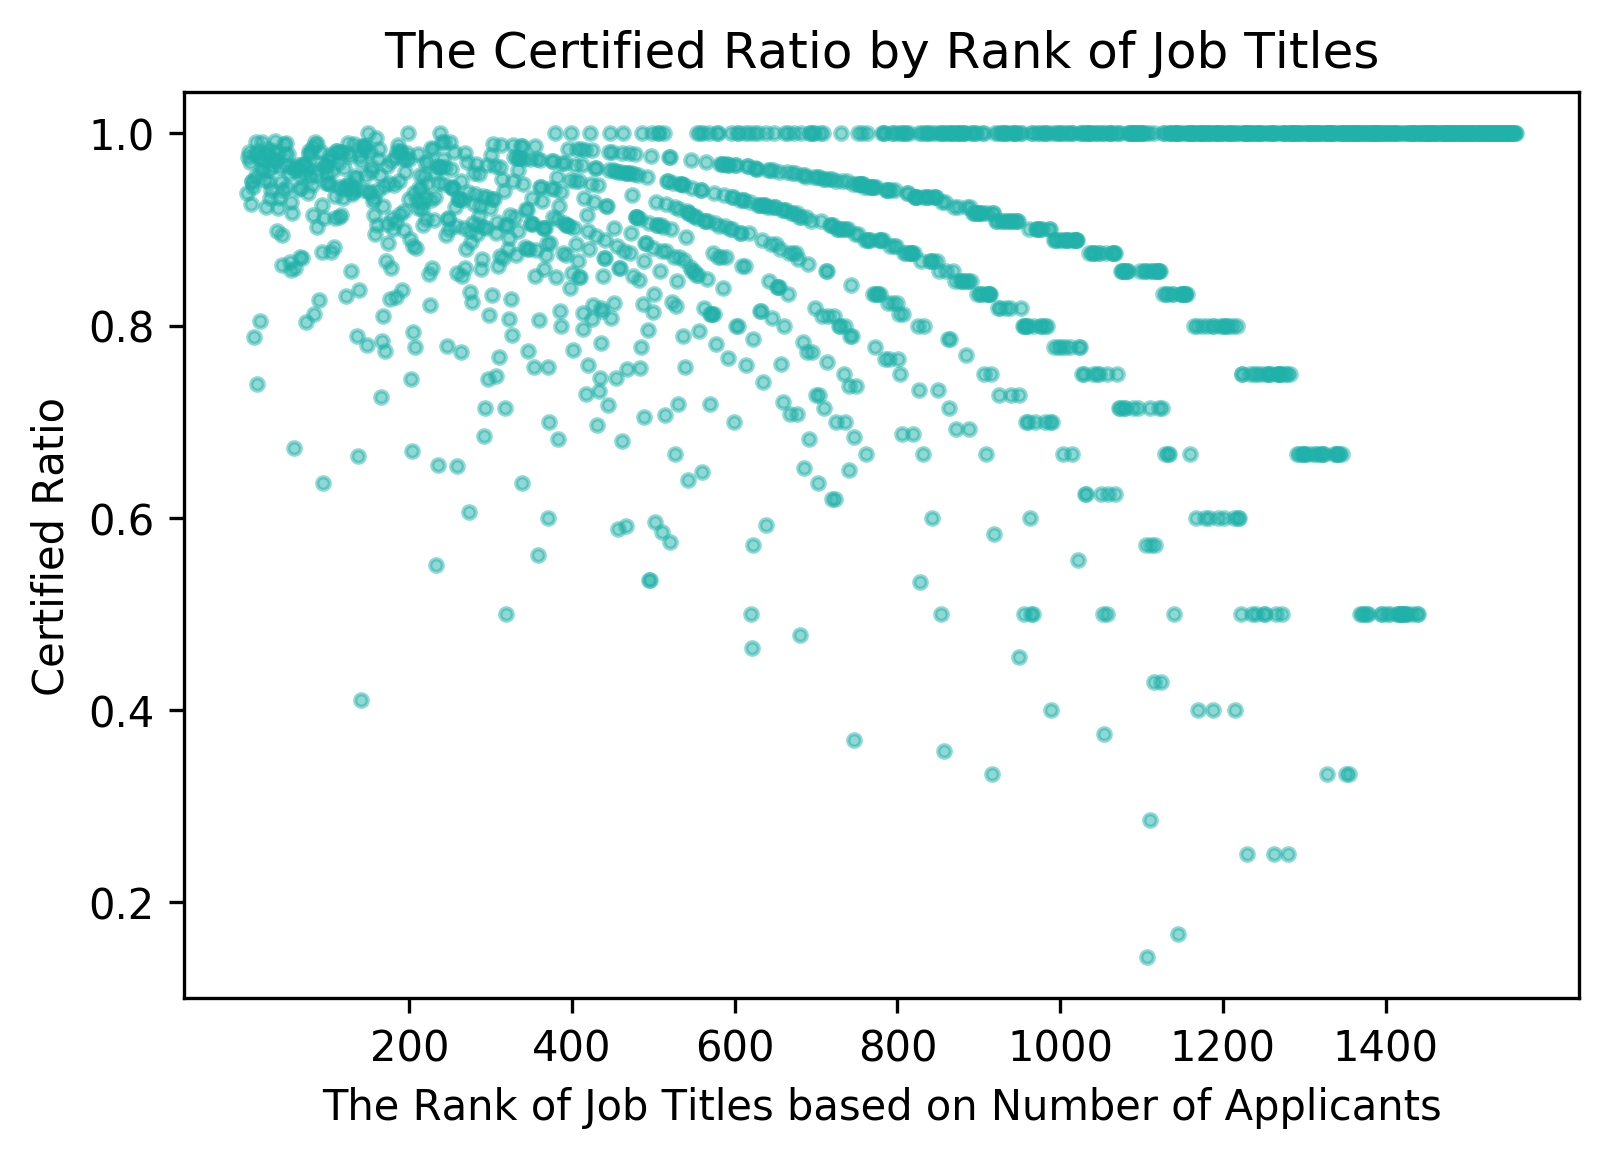

In [15]:
# Plot the ratio of applicants with the number of applicants based on Job. 
plt.plot(np.arange(len(job_count))+1,(job_count.ratio),".",alpha=.5,
         color="lightseagreen")
plt.xticks(((np.arange(len(job_count))+1))[199::200])
plt.ylabel("Certified Ratio")
plt.title("The Certified Ratio by Rank of Job Titles")
plt.xlabel("The Rank of Job Titles based on Number of Applicants")

plt.show()

Based on the graph above, there is a lot less variance in certified ratios with higher ranked job titles. This means that the job titles that have more applicants corresponding to it have a certified ratio between 0.8-1.0. We also see that as the rank of the job decreases there is higher variance in certified ratio. If the job title is ranked from 1000 and on, the certified ratio is be anywhere between 0 and 1. 

Note that the distribution of the number of jobs can also play an affect on the graph above. The data frame below depicts the distribution of the number of applicants across job categories. There are 44 job titles that have more than 1000 applicants, 226 with between 100-1000 applicants while over 82% of the jobs have less than 100 applicants. This means that the lower ranked jobs are highly weighted. Jobs that are ranked lower than 300 and on have only 100 or less applicants. This can be the reason why there is more variance in the graph above, since there is a less number of applicants to account for in the ratios. 

In [16]:
# Distribution of the number of individuals across job categories.
job_amount = {'Count':[len(job_count.query("Applied>1000")),
                        len(job_count.query("Applied<=1000 & Applied>=100")),
                        len(job_count.query("Applied<100"))]}

df = pd.DataFrame(data=job_amount,index=['>1000','100-1000','<100'])
df['Ratio'] = df.Count/len(job_count)
df

,Count,Ratio
>1000,44,0.028205
100-1000,226,0.144872
<100,1290,0.826923


## Unit of Pay 

One of the variables in our data is called `pw_unit_of_pay_9089`. This variable indicates whether the proposed salary for this employee is going to be yearly, monthly, weekly, bi-weekly, or hourly. 

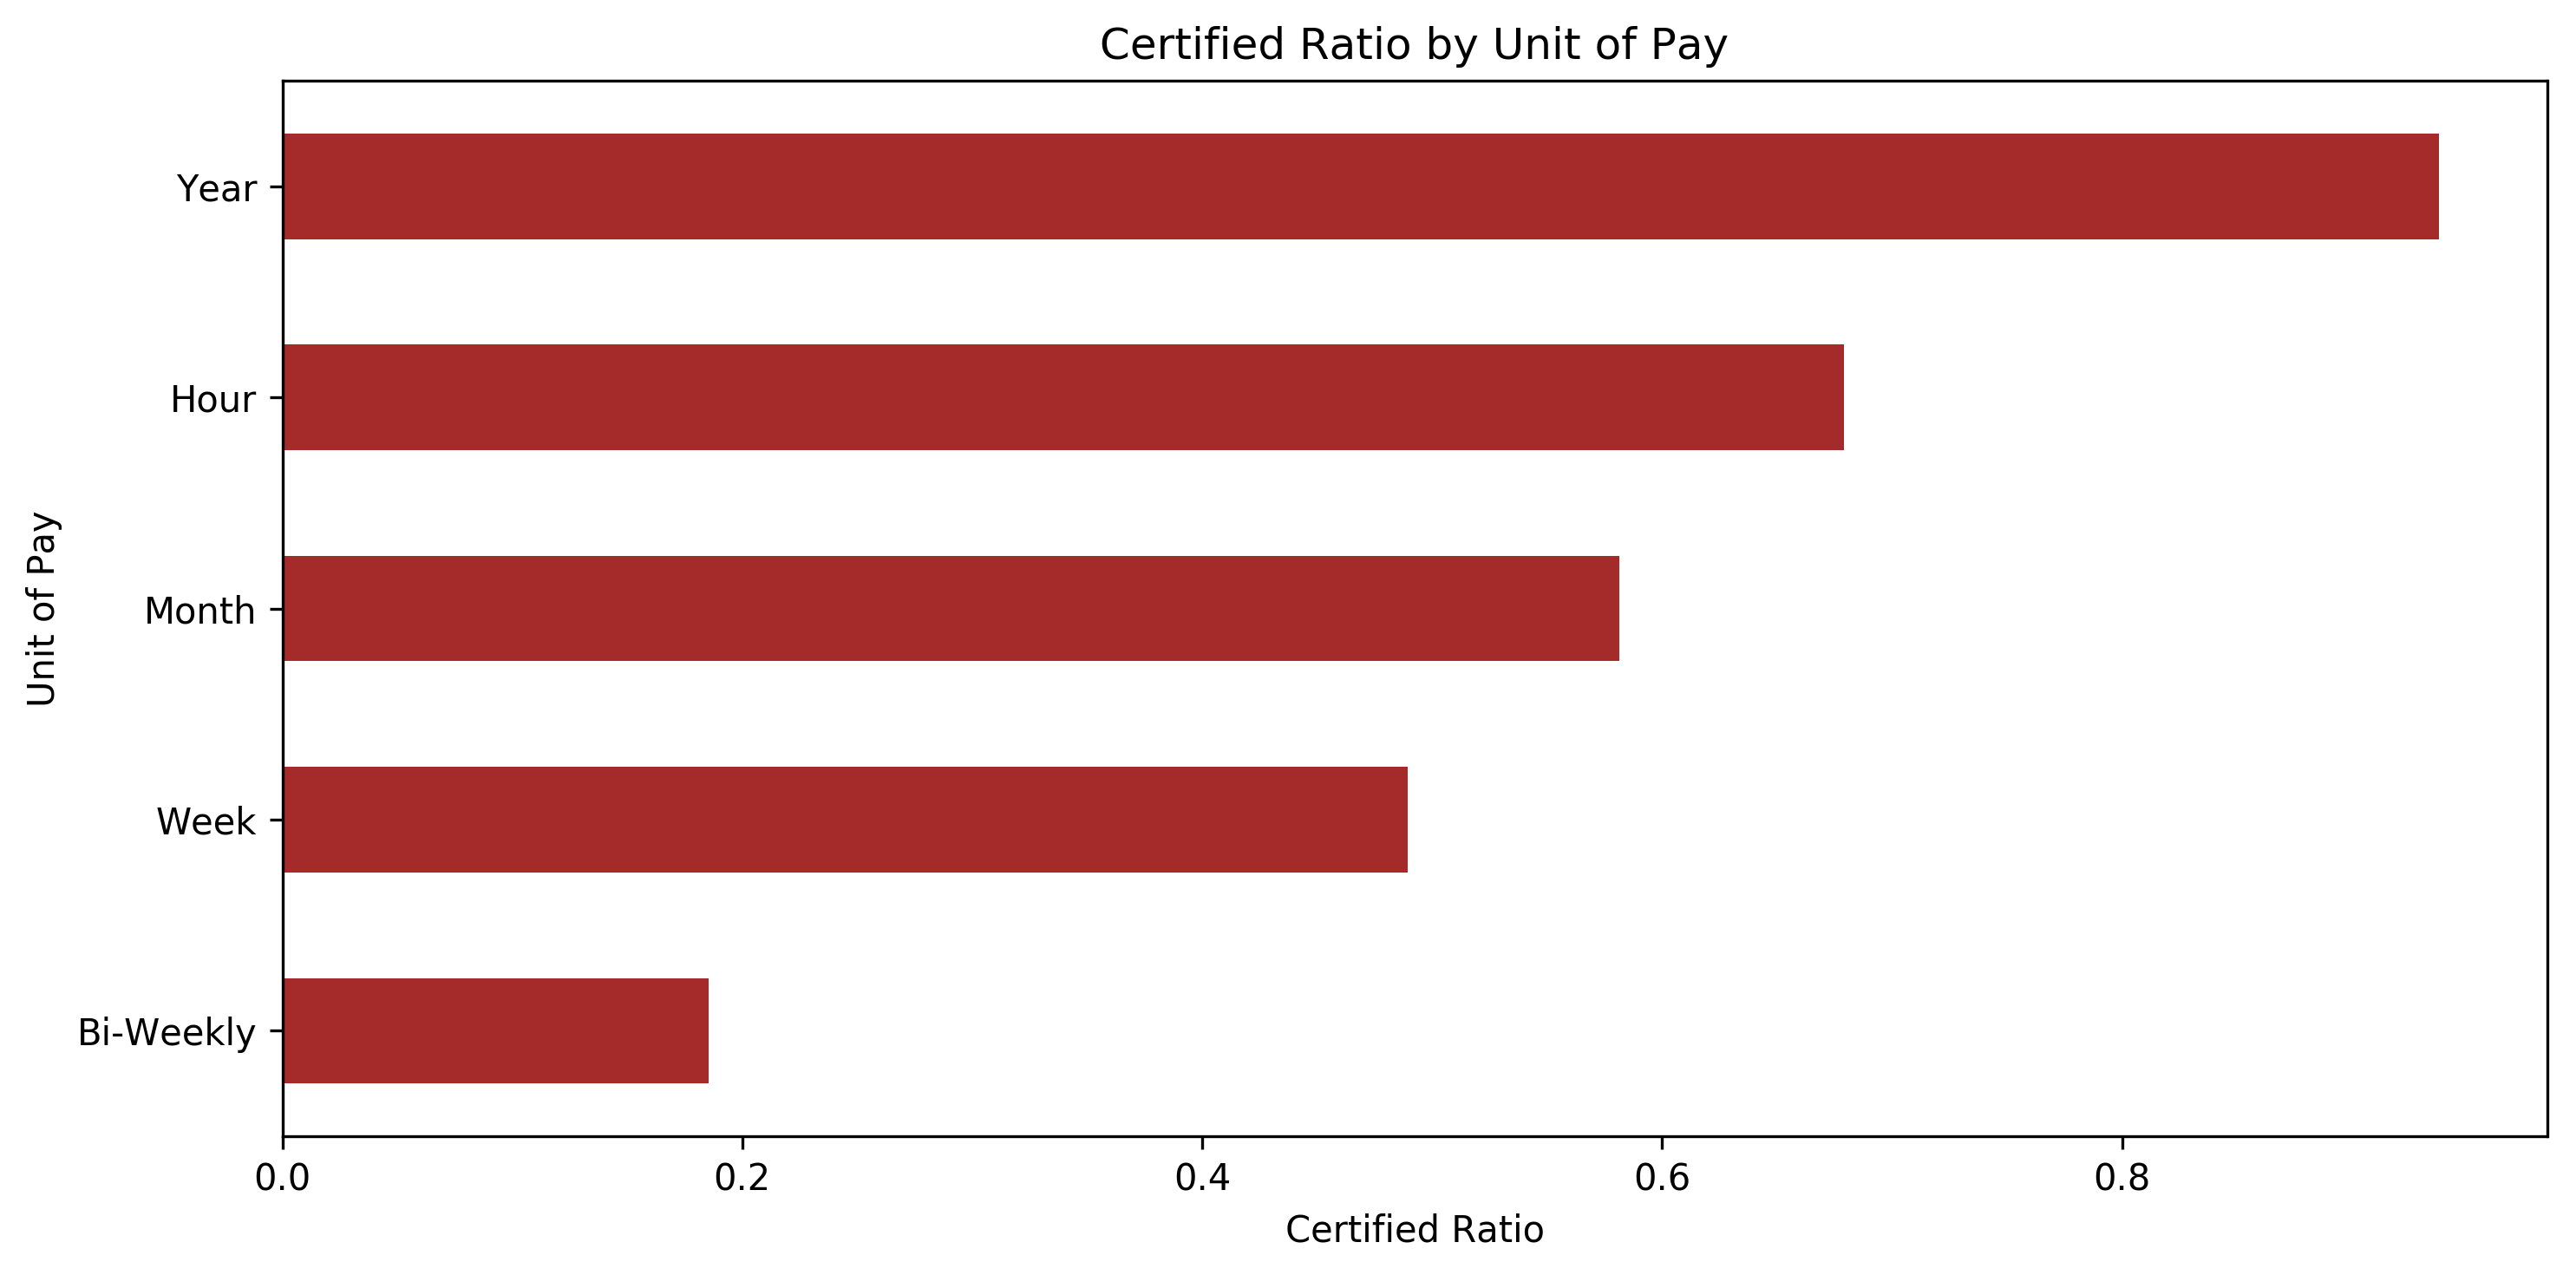

In [17]:
# Get the unit of pay applicant counts and plot the ratio.
pay_count = dp.count_data("pw_unit_of_pay_9089",data)
dp.plot_rate_data(pay_count.sort_values("ratio"),
               "Certified Ratio by Unit of Pay","Unit of Pay")

The plot above describes the certified ratio of labor certification based on the unit of pay of each applicant. The applicants who are going to receive a yearly salary are certified more than 90% of the time in this dataset. Hourly pay has a certification ratio between 60% and 80%, while the other units are lower than 50%.

In [18]:
# The table of application count based on unit of pay. 
pay_count

,Applied,Certified,ratio
Year,345563,324084,0.937843
Hour,7532,5115,0.679102
Week,188,92,0.489362
Month,117,68,0.581197
Bi-Weekly,27,5,0.185185


Based on the table above, one of the reasons the certified ratio for weekly, month, and bi-weekly units of pay are so much lower is due to the number of applicants that fall under that category being much lower. Regardless, the applicants that have a yearly salary have a greater likelihood of being certified than those that do not. 

## Decision Date

Have the trends of labor certifications have changed over time? The decision date variable in our dataset is the year where the certification status is decided. 

In [19]:
# Get decision date count table
year_count = dp.count_data("decision_date",data)
year_count

,Applied,Certified,ratio
2016-01-01,119740,113999,0.952054
2015-01-01,91847,86318,0.939802
2014-01-01,73579,69398,0.943177
2013-01-01,37174,32022,0.861409
2012-01-01,21913,19115,0.872313
2011-01-01,10596,9473,0.894017


Based on the table given above, the certified ratio of labor certification applicants did not change very much from 2011-2013 and 2014-2016. Although there is a slight difference, there is no significant amount of change within these two time periods. It is interesting that the past three years have had such an increase in certification than the three years prior. 

Note that the data for applicants have increased each year, with a dramatic increase from 2014 to 2016. It would be interesting to see whether the number of applicants really has increased or if the amount of available data has increased over the years.

## Refile application

The refile variable in our data indicates whether the application was previously filed. We would think that an application being refiled would give the application a better chance of being certified, but based on the data below, the opposite was true. 

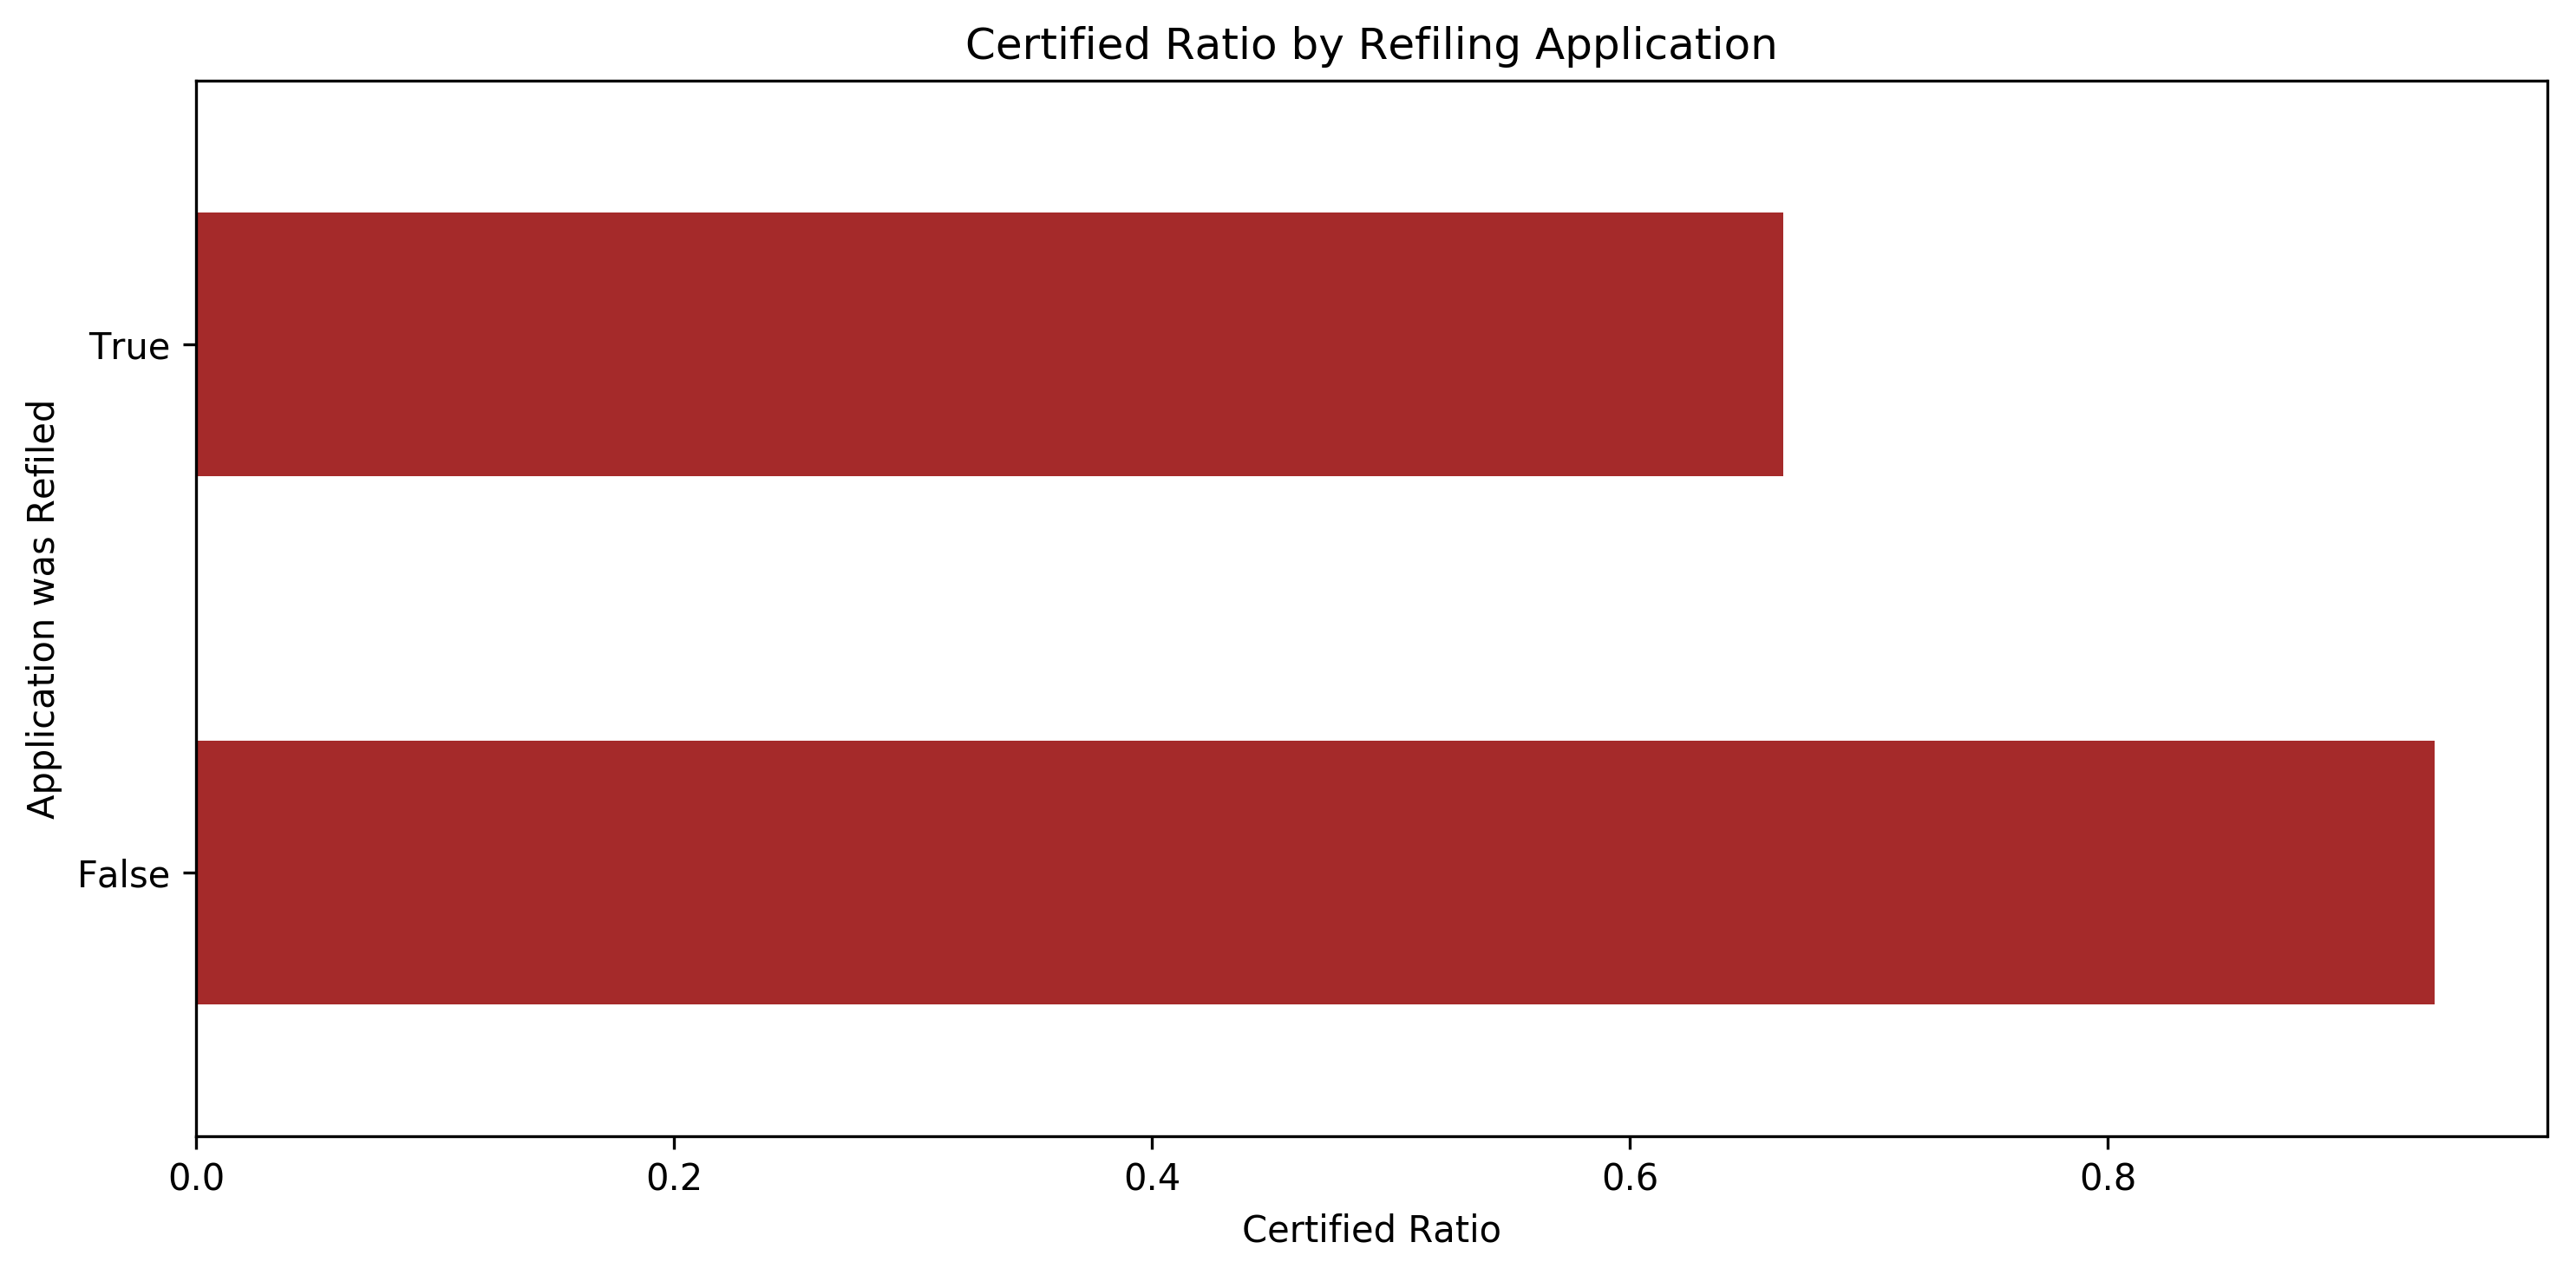

In [20]:
refile_count = dp.count_data("refile",data)
dp.plot_rate_data(refile_count,"Certified Ratio by Refiling Application",
               "Application was Refiled")

The graph above shows that applicants who have indicated that the application is a refile have a lower likelihood of being certified than those who did not indicate that the applicaton is a refile.

## Worker Education
We also looked at the education of workers to see what effects it may have on certification status. We predict that higher education levels with lead to a higher certified ratio.

In [21]:
education_count = dp.count_data("foreign_worker_info_education",data)
education_count.sort_values("ratio")[::-1]

,Applied,Certified,ratio
Medical Degree,4765,4635,0.972718
Doctorate,11743,11412,0.971813
Master's,99722,95773,0.960400
Bachelor's,84470,81105,0.960163
Other,5007,4534,0.905532
Associate's,2204,1813,0.822595
High School,4194,3330,0.793991


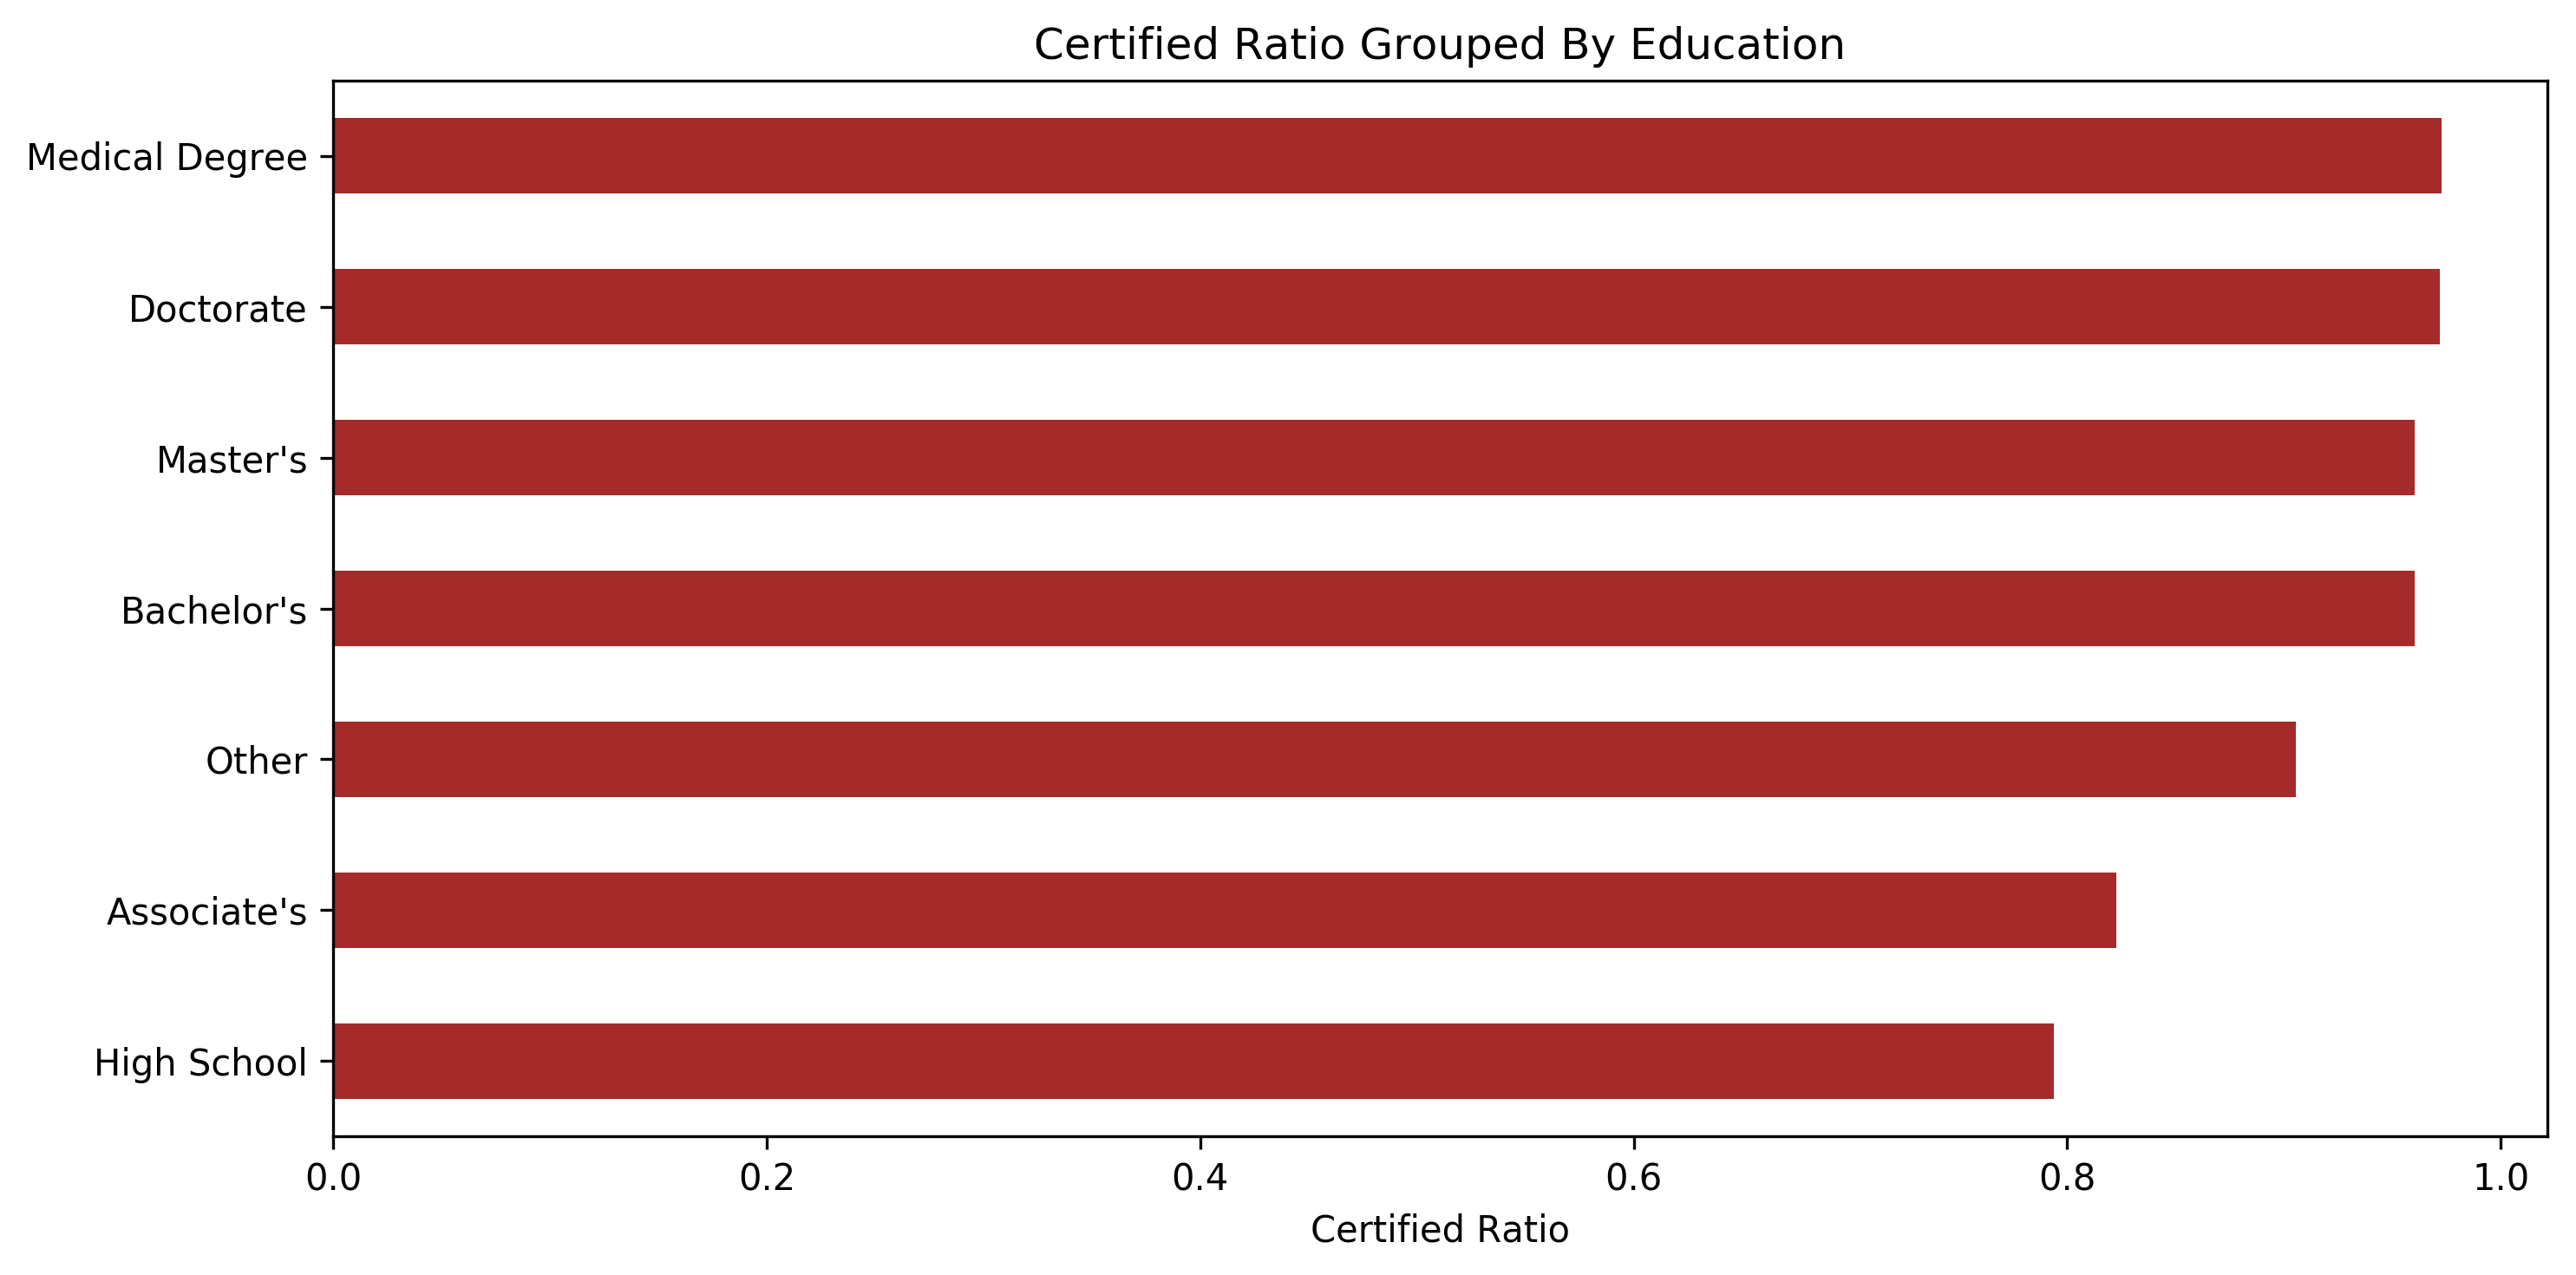

In [22]:
dp.plot_rate_data(education_count.sort_values("ratio"),
                  "Certified Ratio Grouped By Education","")

Based on the table above, the applicants who have a bachelor's degree or higher level of education have more than a 95% chance of receiving their labor certification. Therefore education has a large effect on being certified or not. 

## Agency use
Lastly, does using an agency to help complete an application lead to a higher likelihood of getting certified?

In [23]:
agency_count = dp.count_data("used_agency",data)
agency_count

,Applied,Certified,ratio
True,198010,188547,0.952209
False,156839,141778,0.903972


Based on the table above, about 95% of the applicants that indicated the use of an agency were certified, while 91% of the applicants who did not use an agency were certified. Although there is a slight increase in certified ratio, we are unsure if this difference is significant enough to say that using an agency has an effect. 

# Conclusion

As predicted, states with high application volume have a higher rate of certification than the overall certification ratio. The applicants with a bachelor degree or higher have more than 95% of the applicants certified. In terms of occupation, there are a lot more people who apply for computer science type jobs, which have a broad range of specific job titles. The applications where refile was indicated have a significantly smaller certified rate than those whose applications indicated no refile. Surprisingly, completing an application with the help of an agency gives a marginal boost in likelihood of certification, but the difference is not significant. Another surprising conclusion is if the indicated salary is given as a yearly salary, as opposed to an hourly, weekly, biweekly, or monthly salary, the applicant is much more likely to get certified. Based on the analysis, we were able to determine some factors that positively or negatively affect the certification status. With further analysis, we hope to determine more trends in the application process and determine signficant bias in the United States immigration system. 